Here, we recreate the first two figures of the paper and show how one can integrate these differential equations along complex paths.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special

Here, we have the complex paths, functions to construct them, classes and objects for the differential equations we want to integrate.

In [10]:
weights_lib = { 
                'Euler 1-step 1-order' : [1],
                'Euler 2-step 2-order' : [0.5 +0.5*1j, 0.5-0.5*1j],
                'Euler 2-step 3-order' : [1+1j*np.sqrt(2)/2,-1j*np.sqrt(2)/2],
                'Euler 2-step 3-order exp' : [0.838852+1j*0.604004, 0.161148-1j*0.604004],
                'Euler 2-step symplectic' : [0.5 +0.5*np.sqrt(3)*1j, 0.5-0.5*np.sqrt(3)*1j],
                'Euler 3-step 1-order' : [8.29344624e-01 , 5.95442650e-02, 1-8.29344624e-01-5.95442650e-02],
                'Euler 3-step 3-order' : [0.1867308533646 + 0.480773884550331*1j, 0.626538293270800, 0.1867308533646 - 0.480773884550331*1j],
                'Euler 3-step 2-order' : [0.411741936185254 + 0.430244574248458*1j, 0.176516127629493, 0.411741936185254-0.430244574248458*1j],
                'Euler 4-step 4-order' : [   0.04262665650273905+0.394632953172082*1j,
                                           0.4573733434973006-0.23510048799854047j, 0.4573733434973006+0.23510048799854047j, 0.04262665650273905-0.394632953172082*1j],
'Euler 4-step 5-order' :[0.468161714486717 - 0.26941588085837*1j, 0.160647423722113 + 0.351192187389791*1j,0.335788810038662 + 0.241712151385474*1j, 0.0354020517525083 - 0.323488457916895*1j]}



def pathwise(x, path):
    stepsize = x[1:]-x[:-1]
    contour = [x[0]]
    for i in range(len(x)-1):
        weights = np.cumsum(weights_lib[path])
        substeps = [x[i]+stepsize[i]*weight for weight in weights]
        contour +=substeps
    return np.array(contour)

class IVP(object):
    def __init__(self, f=None, u0=1., t0=0., T=1., exact=None, desc='', name=''):
        self.u0  = u0
        self.rhs = f
        self.T   = T
        self.exact = exact
        self.description = desc
        self.t0 = t0
        self.name = name
        
## Linear 
u0 = 1.
rhs = lambda t,u: u
exact = lambda t, u0=u0: u0*np.exp(t)
linear = IVP(f=rhs, u0=u0, T=5, exact = exact)

## simple harmonic motion y''=-y
u0 = np.array([0, 1])
rhs = lambda t,u: np.dot(np.matrix([[0, 1], [-1, 0] ]), u)
exact = lambda t, u0=u0: np.array([np.sin(t), np.cos(t)]).transpose()
shm = IVP(f=rhs, u0=u0, T=5, exact = exact)

## sin y'= cos(t)
u0 = 0
rhs = lambda t,u: np.cos(t)
exact = lambda t, u0=u0: 1/(1+t)
sin_case = IVP(f=rhs, u0=u0, T=0.5, exact = exact)

## square y''= y**2
u0 = 1
rhs = lambda t,u: u**2
exact = lambda t, u0=u0: u0/(1+u0*t)
square = IVP(f=rhs, u0=u0, T=0.5, exact = exact)

## exp y''= e^y
u0 = 1
rhs = lambda t,u: -np.exp(u)
exact = lambda t, u0=u0: -np.log(t+np.exp(-1))
exponential = IVP(f=rhs, u0=u0, T = 1, exact = exact)

name = 'nlsin'
u0 = 1.
rhs = lambda t,u: 4.*u*np.sin(t)**3*np.cos(t)
exact = lambda t, u0=u0: u0*np.exp((np.sin(t))**4)
description = 'A simple nonlinear scalar problem'
nlsin = IVP(f=rhs, u0=u0, T=5., desc=description, exact=exact, name=name)

name = 'ode1'
rhs = lambda t,u: 4.*t*np.sqrt(u)
exact = lambda t: (1.+t**2)**2
ode1 = IVP(f=rhs, u0=1., T=5., exact=exact, name=name)

name = 'ode2'
u0=np.exp(1.)
rhs = lambda t,u: u/t*np.log(u)
exact = lambda t: np.exp(2.*t)
ode2 = IVP(f=rhs, u0=u0, t0=0.5, T=5., exact=exact, name=name)

name = 'Airy'
t_airy = np.linspace(-5,5, 1000)
ai, aip, bi, bip = special.airy(t_airy)
u0=np.array([ai[0], aip[0]])
rhs = lambda t,u: np.array([ u[1], t*u[0]])
airy = IVP(f=rhs, u0=u0, T=5., exact=exact, name=name)

name = 'vdp'
eps=0.1
u0=np.array([2.,-0.65])
rhs = lambda t,u: np.array([u[1], 1./eps*(-u[0]+(1.-u[0]**2)*u[1])])
description = 'Van der Pol oscillator with epsilon = 1/10.'
vdp = IVP(f=rhs, u0=u0, T=5., exact=exact, name=name, desc=description)

def solve_ivp(ode, t, scheme):
    path1 = pathwise(t, scheme)
    steps = path1[1:]-path1[:-1]
    if isinstance(ode.u0, (list, np.ndarray)):
        y1 = np.zeros((len(path1), len(ode.u0)), dtype = np.clongdouble)
    else:
        y1 = np.zeros((len(path1)), dtype = np.clongdouble)
    y1[0] = ode.u0
    i = 1
    for step in steps:
        y1[i] = y1[i-1] + step*ode.rhs(path1[i-1], y1[i-1])
        if i%int(scheme[6])==0:
            y1[i] = np.real(y1[i])
        i += 1
    return y1

C:\Users\jithi\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\jithi\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\jithi\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\jithi\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\jithi\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\jithi\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: Complex

1.6937762325822139
1.8008725856979706


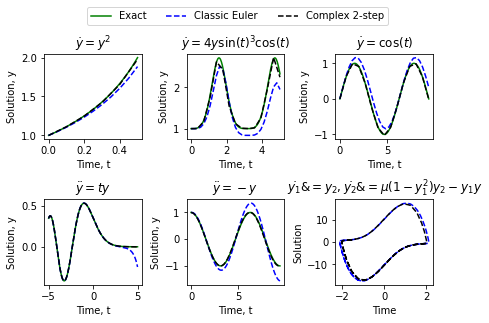

In [11]:
mosaic = """
    ABC
    DEF
    """
fig = plt.figure(constrained_layout=True)
ax_dict = fig.subplot_mosaic(mosaic)

t_exact = np.linspace(0, 3*np.pi, 300)
t = np.linspace(0, 3*np.pi, 30)
t2 = np.linspace(0, 3*np.pi, 15)
solution = solve_ivp(sin_case, t, 'Euler 1-step 1-order')
solution2 = solve_ivp(sin_case, t2, 'Euler 2-step 2-order')
str1= 'C'
ax_dict[str1].plot(t_exact, np.sin(t_exact) , 'g',label ='Exact')
ax_dict[str1].plot(t, solution , 'b--', label = 'Classic Euler')
ax_dict[str1].plot(t2, solution2[::2], 'k--', label = 'Complex 2-step')

ax_dict[str1].set_xlabel('Time, t')
ax_dict[str1].set_ylabel('Solution, y')
ax_dict[str1].set_title(r'$\dot{y}=\cos(t)$')
#ax_dict[str1].legend( fontsize = 6)

t = np.linspace(-5, 5, 30000)
t2 = np.linspace(-5, 5, 15000)
solution = solve_ivp(airy, t, 'Euler 1-step 1-order')
solution2 = solve_ivp(airy, t2, 'Euler 2-step 2-order')
str1= 'D'
ax_dict[str1].plot(t_airy, ai , 'g')
ax_dict[str1].plot(t, solution[:,0] , 'b--',)
ax_dict[str1].plot(t2, solution2[::2, 0], 'k--')

ax_dict[str1].set_xlabel('Time, t')
ax_dict[str1].set_ylabel('Solution, y')
ax_dict[str1].set_title(r'$\ddot{y}=ty$')
#ax_dict[str1].legend( fontsize = 6)

t_exact = np.linspace(0, nlsin.T, 200)
t = np.linspace(0, nlsin.T, 29)
t2 = np.linspace(0, nlsin.T, 15)
solution = solve_ivp(nlsin, t, 'Euler 1-step 1-order')
solution2 = solve_ivp(nlsin, t2, 'Euler 2-step 2-order')
str1= 'B'
ax_dict[str1].plot(t_exact, nlsin.exact(t_exact) , 'g')
ax_dict[str1].plot(t, solution , 'b--')
ax_dict[str1].plot(t2, solution2[::2], 'k--')

ax_dict[str1].set_xlabel('Time, t')
ax_dict[str1].set_ylabel('Solution, y')
ax_dict[str1].set_title(r'$\dot{y}=4y\sin(t)^3\cos(t)$')
#ax_dict[str1].legend( fontsize = 6)

t_end = 0.5
n_end = 6
ini = 1
t_square = np.linspace(0,t_end, 1000)
t = np.linspace(0, t_end, 2*n_end-1)
t2 = np.linspace(0, t_end, n_end)
solution = solve_ivp(square, t, 'Euler 1-step 1-order')
solution2 = solve_ivp(square, t2, 'Euler 2-step 2-order')
str1= 'A'
ax_dict[str1].plot(t_square , ini/(1-ini*t_square ) , 'g')
ax_dict[str1].plot(t, solution , 'b--')
ax_dict[str1].plot(t2, solution2[::2], 'k--')
ax_dict[str1].set_xlabel('Time, t')
ax_dict[str1].set_ylabel('Solution, y')
ax_dict[str1].set_title(r'$\dot{y}=y^2$')
print(np.linalg.norm(ini/(1+ini*t2)-solution[::2]))
print(np.linalg.norm(ini/(1+ini*t2)-solution2[::2]))
#ax_dict[str1].legend( bbox_to_anchor=(3.1, 1.5), fontsize = 10)






t = np.linspace(0, 3*np.pi, 100)
t2 = np.linspace(0, 3*np.pi, 50)
solution = solve_ivp(shm, t, 'Euler 1-step 1-order')
solution2 = solve_ivp(shm, t2, 'Euler 2-step 2-order')
str1= 'E'
ax_dict[str1].plot(t, np.cos(t) , 'g')
ax_dict[str1].plot(t, solution[:,1] , 'b--')
ax_dict[str1].plot(t2, solution2[::2,1], 'k--')

ax_dict[str1].set_xlabel('Time, t')
ax_dict[str1].set_ylabel('Solution, y')
ax_dict[str1].set_title(r'$\ddot{y}= -y$')
#ax_dict[str1].legend( fontsize = 6 , loc = 'lower left')

t = np.linspace(0, vdp.T, 500)
t2 = np.linspace(0, vdp.T, 250)
solution = solve_ivp(vdp, t, 'Euler 1-step 1-order')
solution2 = solve_ivp(vdp, t2, 'Euler 2-step 2-order')
str1= 'F'
ax_dict[str1].plot(solution[:,0], solution[:,1] , 'b--')
ax_dict[str1].plot(solution2[:,0], solution2[:,1], 'k--')
#ax_dict[str1].plot(t, np.cos(t) , 'g',label ='Exact')
ax_dict[str1].set_xlabel('Time')
ax_dict[str1].set_ylabel('Solution')
ax_dict[str1].set_title(r'$\dot{y_1} &= y_2,  \dot{y_2} &= \mu(1-y_1^2)y_2-y_1y$')
#ax_dict[str1].legend( fontsize = 6 , loc = 'lower left')
fig.legend( bbox_to_anchor=(0.9, 1.1), ncol =3, fontsize = 10)
plt.savefig('sec2_2_v2.pdf', bbox_inches="tight")

#identify_axes(ax_dict)
#plt.show()

C:\Users\jithi\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\jithi\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


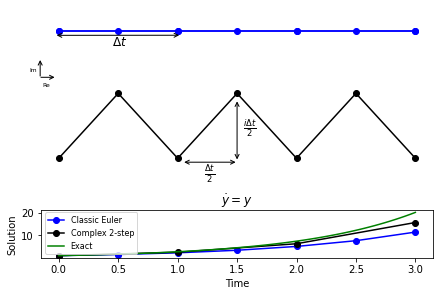

In [12]:
#fig = plt.figure(constrained_layout=True)
mosaic1 = """
    A
    A
    B
    B
    B
    C
    C
    """
ax_dict = plt.figure(constrained_layout=True).subplot_mosaic(mosaic1)
t = np.linspace(0, 3, 4)
t2 = np.linspace(0, 3, 7)

ax_dict['A'].plot(t, np.zeros(len(t)) , 'b-o', label = 'Classic Euler')
ax_dict['A'].plot(t2, np.zeros(len(t2)) , 'b-o', label = 'Classic Euler')
ax_dict['A'].axis('off')
ax_dict['A'].annotate("", xy=(0.035, 0.4), xycoords="axes fraction",  # (1, 0.5) of the an1's bbox
                  xytext=(130, 0.1), textcoords="offset points",
                  va="center", ha="center",
                  bbox=dict(boxstyle="round", fc="w"),
                  arrowprops=dict(arrowstyle="<->"))

ax_dict['A'].text( 0.45, -0.035, r"$\Delta t$", size=12)
td = pathwise(t, 'Euler 2-step 2-order')
ax_dict['B'].plot(np.real(td), np.imag(td) , 'k-o', label = 'Classic Euler')
ax_dict['B'].axis('off')
ax_dict['B'].annotate("", xy=(0.36, -0.01), xycoords="axes fraction",
                      rotation = 90,# (1, 0.5) of the an1's bbox
                  xytext=(64, 0), textcoords="offset points",
                  va="center", ha="center",
                  bbox=dict(boxstyle="round", fc="w"),
                  arrowprops=dict(arrowstyle="<->"))
ax_dict['B'].annotate("", xy=(0.5, 0), xycoords="axes fraction",# (1, 0.5) of the an1's bbox
                  xytext=(0.5, 0.99), textcoords="axes fraction",
                  va="center", ha="center",
                  bbox=dict(boxstyle="round", fc="w"),
                  arrowprops=dict(arrowstyle="<->"))

ax_dict['B'].text( 1.22, -0.15, r"$\frac{\Delta t}{2}$", size=12)
ax_dict['B'].text( 1.55, 0.2, r"$\frac{i\Delta t}{2}$", size=12)
ax_dict['B'].annotate("", xy=(-0.002, 1.45), xycoords="axes fraction",# (1, 0.5) of the an1's bbox
                  xytext=(-0.002, 1.05), textcoords="axes fraction",
                  va="center", ha="center",
                  bbox=dict(boxstyle="round", fc="w"),
                  arrowprops=dict(arrowstyle="->"))
ax_dict['B'].annotate("", xy=(0.04, 1.18), xycoords="axes fraction",# (1, 0.5) of the an1's bbox
                  xytext=(-0.014, 1.18), textcoords="axes fraction",
                  va="center", ha="center",
                  bbox=dict(boxstyle="round", fc="w"),
                  arrowprops=dict(arrowstyle="->"))
ax_dict['B'].text( -0.135, 0.55, "Re", size=6)

ax_dict['B'].text( -0.25, 0.668, "Im", size=6)



t5 = np.linspace(0, 3, 70)
t3 = np.linspace(0, 3, 7)
t4 = np.linspace(0, 3, 4)
solution = solve_ivp(linear, t3, 'Euler 1-step 1-order')
solution2 = solve_ivp(linear, t4, 'Euler 2-step 2-order')
str1= 'C'
ax_dict[str1].plot(t3, solution , 'b-o', label = 'Classic Euler')
ax_dict[str1].plot(t4, solution2[::2], 'k-o', label = 'Complex 2-step')
ax_dict[str1].plot(t5, np.exp(t5) , 'g',label ='Exact')
ax_dict[str1].set_xlabel('Time')
ax_dict[str1].set_ylabel('Solution')
ax_dict[str1].set_title(r'$\dot{y}=y$')
ax_dict[str1].legend( fontsize = 8)
plt.savefig('sec2_1_v2.pdf')

#ax_dict['C'].plot(t, solution , 'b', label = 'Classic Euler')
#ax_dict['D'].plot(t, solution , 'b', label = 'Classic Euler')
#ax_dict['E'].plot(t, solution , 'b', label = 'Classic Euler')
#identify_axes(ax_dict)